# Imports

Enable operations to use the cpu if no Apple gpu implementation is available

In [1]:
from sympy.stats.sampling.sample_numpy import numpy
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


Reload modules automagically if they change

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import json
import sklearn
import ot
import torch
from sklearn.svm import SVC
from Utils.SVM_utils import test_svm, train_svm
from einops import rearrange
from Utils.visualization_utils import visualize_barycenter_diracs, plot_images, plot_pca_for_arrays
from Utils.joint_OT_mapping_linear_classreg import free_support_sinkhorn_barycenter, compute_joint_OT_mapping
from warnings import catch_warnings
from map_hyperparam import optimize_hyperparams

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

# Data

In [5]:
data_path = '/Users/balazsmorvay/PycharmProjects/fmri_classifier/Data/Office-Caltech'

Read the image features

In [6]:
dataset = np.load(os.path.join(data_path, 'Objects_Decaf.npy'))
with open(os.path.join(data_path, 'Objects_crossval_index.json'), 'r') as f:
    fold_dict = json.loads(f.read())

domain_names = ['Webcam', 'Amazon', 'dslr', 'Caltech']

Set the number of classes within each domain

In [7]:
n_classes = 10
standardize = True

In [8]:
dataset.shape

(2533, 4098)

In [9]:
X = dataset[:, :-2]
if standardize:
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
else:
    # Feature scaling
    X = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

y = np.array(dataset[:, -2], dtype=int)
m = np.array(dataset[:, -1], dtype=int)
domains = np.unique(m).astype(int)
targets = domains
n_domains = len(domains)

Dataset has shape n_points x n_features

In [10]:
X.shape, y.shape, targets.shape

((2533, 4096), (2533,), (4,))

### Number of samples coming from a given domain, having a given class

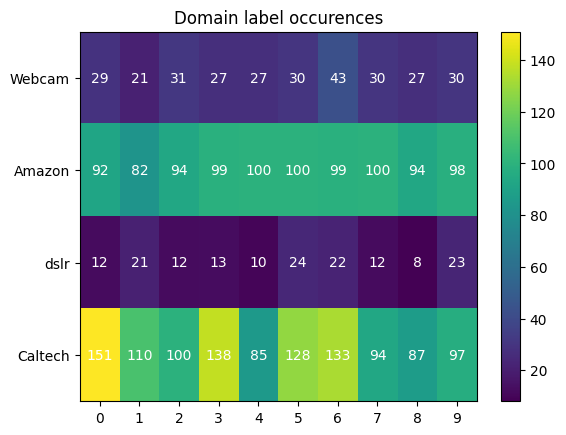

In [11]:
label_domain_occurence = np.zeros((4, 10), dtype=int)
for label in range(10):
    for i, domain in enumerate(domains):
        domain_indices = np.where(m == domain)
        domain_labels = y[domain_indices]
        label_indices = np.where(domain_labels == label+1)
        label_domain_occurence[i][label] = len(label_indices[0])

fig, ax = plt.subplots()
cax = ax.imshow(label_domain_occurence, cmap='viridis', aspect='auto')
for (i, j), val in np.ndenumerate(label_domain_occurence):
    ax.text(j, i, f'{val}', ha='center', va='center', color='white')
fig.colorbar(cax)
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(4))
ax.set_xticklabels(str(i) for i in range(10))
ax.set_yticklabels(domain_names)
plt.title('Domain label occurences')
plt.show()

# Training

In [12]:
X_all = []
y_all = []
for i, domain in enumerate(domains):
    domain_indices = np.where(m == domain)
    X_all.append(torch.tensor(X[domain_indices], dtype=torch.float32, device=device))
    y_all.append(torch.tensor(y[domain_indices], dtype=torch.int, device=device))

In [13]:
X_trains = []
X_tests = []
y_trains = []
y_tests = []

for i in range(len(X_all)):
    X_i = X_all[i].cpu()
    y_i = y_all[i].cpu()
    X_i_train, X_i_test, y_i_train, y_i_test = sklearn.model_selection.train_test_split(X_i, y_i, train_size=0.3, shuffle=True, stratify=y_i, random_state=42)
    X_trains.append(X_i_train.to(device))
    X_tests.append(X_i_test.to(device))
    y_trains.append(y_i_train.to(device))
    y_tests.append(y_i_test.to(device))

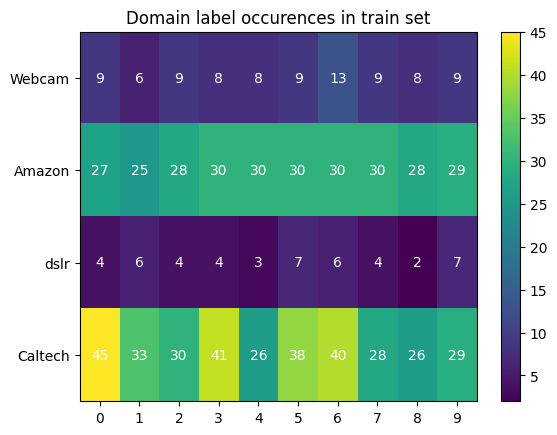

In [15]:
label_domain_occurence = np.zeros((4, 10), dtype=int)
for label in range(10):
    for i in range(n_domains):
        domain_labels = y_trains[i]
        label_indices = np.where(domain_labels.cpu() == label+1)
        label_domain_occurence[i][label] = len(label_indices[0])

fig, ax = plt.subplots()
cax = ax.imshow(label_domain_occurence, cmap='viridis', aspect='auto')
for (i, j), val in np.ndenumerate(label_domain_occurence):
    ax.text(j, i, f'{val}', ha='center', va='center', color='white')
fig.colorbar(cax)
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(4))
ax.set_xticklabels(str(i) for i in range(10))
ax.set_yticklabels(domain_names)
plt.title('Domain label occurences in train set')
plt.show()

Concatenate the train samples into one tensor

In [16]:
Xs = torch.concatenate(tensors=X_trains, dim=0)
ys = torch.concatenate(y_trains, dim=0)
Xs.shape, ys.shape

(torch.Size([758, 4096]), torch.Size([758]))

In [17]:
n_features = 4096

In [18]:
model = train_svm(X_trains[0].cpu(), y_trains[0].cpu(), kernel='rbf', C=1.0)
model.fit_status_ == 0

[LibSVM].*.*
optimization finished, #iter = 31
obj = -4.743459, rho = 0.194978
nSV = 15, nBSV = 0
.*
optimization finished, #iter = 35
obj = -5.609956, rho = 0.145199
nSV = 18, nBSV = 1
.*.*
optimization finished, #iter = 35
obj = -6.090518, rho = 0.401297
nSV = 17, nBSV = 1
.*.*
optimization finished, #iter = 38
obj = -4.402343, rho = 0.384378
nSV = 17, nBSV = 0
.*.*
optimization finished, #iter = 37
obj = -5.571213, rho = 0.343603
nSV = 18, nBSV = 0
.*
optimization finished, #iter = 40
obj = -6.889827, rho = 0.372778
nSV = 22, nBSV = 5
.*
optimization finished, #iter = 29
obj = -6.557554, rho = 0.238393
nSV = 18, nBSV = 5
.*.*
optimization finished, #iter = 36
obj = -4.187777, rho = 0.328174
nSV = 17, nBSV = 0
.*
optimization finished, #iter = 28
obj = -6.734039, rho = 0.309930
nSV = 18, nBSV = 4
.*.*
optimization finished, #iter = 31
obj = -4.704163, rho = -0.061754
nSV = 15, nBSV = 0
.*.*
optimization finished, #iter = 29
obj = -5.388725, rho = 0.177659
nSV = 14, nBSV = 0
.*
optimi

True

{'accuracy': 0.5714285714285714, 'recall': array([0.33333333, 0.84      , 0.60714286, 0.7       , 0.46666667,
       0.26666667, 0.93333333, 0.6       , 0.        , 0.96551724]), 'precision': array([0.9       , 1.        , 0.62962963, 0.75      , 0.73684211,
       0.88888889, 0.26415094, 1.        , 0.        , 0.57142857]), 'fscore': array([0.48648649, 0.91304348, 0.61818182, 0.72413793, 0.57142857,
       0.41025641, 0.41176471, 0.75      , 0.        , 0.71794872])}


/Users/balazsmorvay/anaconda3/envs/fmri_classifier/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


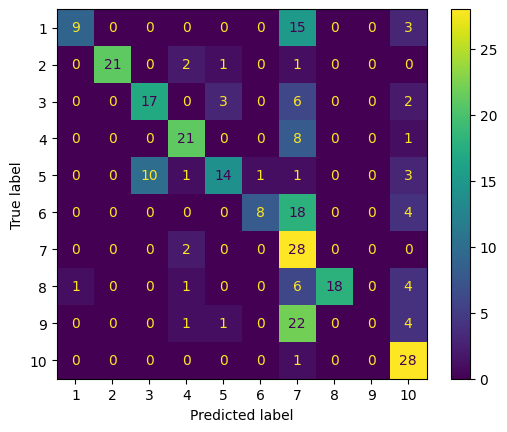

In [26]:
metrics, disp = test_svm(model, X_trains[1].cpu(), y_trains[1].cpu())
disp.plot()
print(metrics)

In [ ]:
model = train_svm(barycenter.cpu(), yt.cpu(), kernel='rbf', C=1.0)
model.fit_status_ == 0

In [49]:
xs = X_trains[1].cpu()
xt = X_trains[0].cpu()
ys = y_trains[1].cpu()
yt = y_trains[0].cpu()
M = ot.dist(xs, xt).cpu().numpy()

a = [1.0 / xs.shape[0]] * xs.shape[0]
b = [1.0 / xt.shape[0]] * xt.shape[0]

P = ot.sinkhorn(a=a, b=b, reg=1e-2, M=M, method='sinkhorn_log')

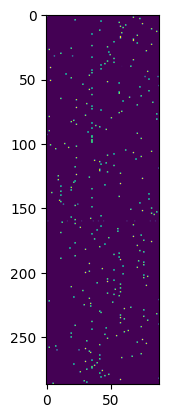

In [50]:
plt.imshow(P)

In [53]:
def transform(xs, xt, xnew, coupling, batch_size=10):
    nx = np

    if nx.array_equal(xs, xnew):
        # perform standard barycentric mapping
        transp = coupling / nx.sum(coupling, axis=1)[:, None]

        # set nans to 0
        transp = nx.nan_to_num(transp, nan=0, posinf=0, neginf=0)

        # compute transported samples
        transp_Xs = nx.dot(transp, xt)
    else:
        # perform out of sample mapping
        indices = nx.arange(xnew.shape[0])
        batch_ind = [
            indices[i:i + batch_size]
            for i in range(0, len(indices), batch_size)]

        transp_Xs = []
        for bi in batch_ind:
            # get the nearest neighbor in the source domain
            D0 = ot.dist(xnew[bi], xs)
            idx = nx.argmin(D0, axis=1)

            # transport the source samples
            transp = coupling / nx.sum(coupling, axis=1)[:, None]
            transp = nx.nan_to_num(transp, nan=0, posinf=0, neginf=0)
            transp_Xs_ = nx.dot(transp, xt)

            # define the transported points
            transp_Xs_ = transp_Xs_[idx, :] + xnew[bi] - xs[idx, :]

            transp_Xs.append(transp_Xs_)

        transp_Xs = nx.concatenate(transp_Xs, axis=0)

    return transp_Xs

In [54]:
transp_xs = transform(xs, xt, xs, P)

{'accuracy': 0.6724738675958188, 'recall': array([0.55555556, 0.92      , 0.92857143, 0.76666667, 0.53333333,
       0.66666667, 0.73333333, 0.63333333, 0.53571429, 0.48275862]), 'precision': array([0.68181818, 0.88461538, 0.57777778, 0.60526316, 0.84210526,
       0.71428571, 0.62857143, 0.7037037 , 0.57692308, 0.66666667]), 'fscore': array([0.6122449 , 0.90196078, 0.71232877, 0.67647059, 0.65306122,
       0.68965517, 0.67692308, 0.66666667, 0.55555556, 0.56      ])}


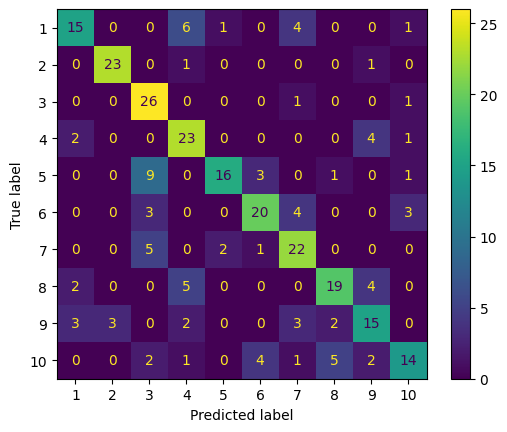

In [55]:
metrics, disp = test_svm(model, transp_xs, y_trains[1].cpu())
disp.plot()
print(metrics)